In [197]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from pymongo import MongoClient

In [198]:
mongo_client = MongoClient("mongodb+srv://<user>:<password>@okcupid.njnu4m5.mongodb.net/") #Update Your Code Here
mongo_database = mongo_client.OKCupid
mongo_collection = mongo_database.OKCupid

In [199]:
all_documents = mongo_collection.find().limit(10)
all_documents[0]

{'_id': ObjectId('66043c9f0d794818da3d5519'),
 'age': 29,
 'status': 'single',
 'sex': 'm',
 'orientation': 'straight',
 'body_type': 'average',
 'diet': 'mostly anything',
 'drinks': 'socially',
 'education': 'graduated from college/university',
 'ethnicity': 'white',
 'height': 67,
 'income': -1,
 'job': 'computer / hardware / software',
 'last_online': '2012-06-29-19-18',
 'location': 'san francisco, california',
 'offspring': "doesn't have kids, but might want them",
 'pets': 'likes cats',
 'religion': 'atheism',
 'sign': 'taurus',
 'smokes': 'no',
 'speaks': 'english (fluently), chinese (okay)',
 'essay0': "i'm an australian living in san francisco, but don't hold that against me. i spend most of my days trying to build cool stuff for my company. i speak mandarin and have been known to bust out chinese songs at karaoke. i'm pretty cheeky. someone asked me if that meant something about my arse, which i find really funny.  i'm a little oddball. i have a wild imagination; i like to t

In [200]:
# Define the aggregation pipeline
matching_pipeline = [
    # Match documents where age, body type, and essay fields are present
    {
        '$match': {
            '$and': [
                {'age': {'$exists': True, '$type': 'int'}},
                {'body_type': {'$exists': True, '$nin': [None, '', 'null']}},
                {'$or': [
                        {'essay0': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay1': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay2': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay3': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay4': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay5': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay6': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay7': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay8': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}},
                    {'essay9': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}}
                ]}
            ]
        }
    },

    # Project fields for analysis
    {
        '$project': {
            'age': {'$toString': '$age'},
            'height': {'$toString': '$height'},
            'body_type': {'$toString': '$body_type'},
            'essay0': {'$cond': [{'$isArray': ['$essay0']}, {'$reduce': {'input': '$essay0', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay0', '']}}]},
            'essay1': {'$cond': [{'$isArray': ['$essay1']}, {'$reduce': {'input': '$essay1', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay1', '']}}]},
            'essay2': {'$cond': [{'$isArray': ['$essay2']}, {'$reduce': {'input': '$essay2', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay2', '']}}]},
            'essay3': {'$cond': [{'$isArray': ['$essay3']}, {'$reduce': {'input': '$essay3', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay3', '']}}]},
            'essay4': {'$cond': [{'$isArray': ['$essay4']}, {'$reduce': {'input': '$essay4', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay4', '']}}]},
            'essay5': {'$cond': [{'$isArray': ['$essay5']}, {'$reduce': {'input': '$essay5', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay5', '']}}]},
            'essay6': {'$cond': [{'$isArray': ['$essay6']}, {'$reduce': {'input': '$essay6', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay6', '']}}]},
            'essay7': {'$cond': [{'$isArray': ['$essay7']}, {'$reduce': {'input': '$essay7', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay7', '']}}]},
            'essay8': {'$cond': [{'$isArray': ['$essay8']}, {'$reduce': {'input': '$essay8', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay8', '']}}]},
            'essay9': {'$cond': [{'$isArray': ['$essay9']}, {'$reduce': {'input': '$essay9', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay9', '']}}]}
        }
    },

    # Add a field to categorize age groups
    {
        '$addFields': {
            'age_group': {
                '$switch': {
                    'branches': [
                        {'case': {'$and': [{'$gte': ["$age", "19"]}, {'$lte': ["$age", "35"]}]}, 'then': "19-35"},
                        {'case': {'$and': [{'$gte': ["$age", "36"]}, {'$lte': ["$age", "45"]}]}, 'then': "36-45"},
                    ],
                    'default': "Other"
                }
            }
        }
    },

    {
        '$group': {
            '_id': {'age_group': "$age_group", 'body_type': "$body_type"},
            'avg_height': {'$avg': {'$toDouble': "$height"}},
            'count': {'$sum': 1},
            'essay0': {'$push': '$essay0'},
            'essay1': {'$push': '$essay1'},
            'essay2': {'$push': '$essay2'},
            'essay3': {'$push': '$essay3'},
            'essay4': {'$push': '$essay4'},
            'essay5': {'$push': '$essay5'},
        }
    },

    # Continue the pipeline from the $group stage
    {
        '$group': {
            '_id': '$_id',
            'avg_height': {'$first': '$avg_height'},
            'count': {'$first': '$count'},
            'essays': {
                '$push': {
                    '$concatArrays': [
                        '$essay0', '$essay1', '$essay2', '$essay3', '$essay4', '$essay5'
                    ]
                }
            }
        }
    },
    
    # Flatten the essays array
    {
        '$addFields': {
            'essays': {
                '$reduce': {
                    'input': '$essays',
                    'initialValue': [],
                    'in': {
                        '$concatArrays': ['$$value', '$$this']
                    }
                }
            }
        }
    },
    
    # Add total count
    {
        '$group': {
            '_id': None,
            'total_count': {'$sum': '$count'},
            'data': {'$push': '$$ROOT'}
        }
    },
    
    # Unwind the data array
    {
        '$unwind': '$data'
    },
    
    # Project the final structure and calculate percentage
    {
        '$project': {
            '_id': '$data._id',
            'avg_height': '$data.avg_height',
            'count': '$data.count',
            'essays': '$data.essays',
            'total_count': '$total_count',
            'percentage': {
                '$multiply': [{'$divide': ['$data.count', '$total_count']}, 100]
            }
        }
    },
]

# Execute the aggregation pipeline
matching_results = list(mongo_database.OKCupid.aggregate(matching_pipeline, allowDiskUse=True))

In [201]:
len(matching_results)

36

In [202]:
matching_results[0]

{'_id': {'age_group': '36-45', 'body_type': 'fit'},
 'avg_height': 68.34578696343402,
 'count': 2516,
 'essays': ['',
  'welcome to my profile, your search is now over.  i love mountain biking, sketching in nature, urban hikes, camping, climbing, yoga classes, getting really hungry and then eating, cyclocross, bike touring and spending time with friends doing those things (some of those things are not nearly as fun to do alone)',
  "i don't really like summarizing myself; but who does, right? seems like every time i try i come up with a pile of contradictions. i'm a shy extrovert i'm a grounded dreamer i'm a lazy adventurer i'm open-minded, but sometimes stubborn i'm a city person, i'm a mountain man i can be very competitive, but try to avoid competition i'm very social, i'm a bit misanthropic i'm generally very meticulous, i'm often sort of careless i have a strong sense of self, i'm a social chameleon i have complete confidence in myself to succeed at whatever i do, yet i'm often te

In [203]:
def plot_age_body_height(results):
    # Extracting data for plotting
    age_groups = []
    body_types = []
    avg_heights = []
    percentages = []
    
    for result in results:
        age_group = result['_id']['age_group']
        body_type = result['_id']['body_type']
        avg_height = result['avg_height']
        body_types_count = result['count']
        percentage = result['percentage']
        
        
        age_groups.append(age_group)
        body_types.append(body_type)
        avg_heights.append(avg_height)
        percentages.append(percentage)
        
    df = pd.DataFrame({
        'Age Group': age_groups,
        'Body Type': body_types,
        'Average Height': avg_heights,
        'Percentage': percentages
    })
    
    # Plotting
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Age Group', y='Average Height', hue='Body Type', data=df)
    plt.title('Average Height by Age Group and Body Type')
    plt.xlabel('Age Group')
    plt.ylabel('Average Height')
    plt.xticks(rotation=45)
    
    # Creating a custom legend
    unique_age_groups = df['Age Group'].unique()
    
    legend_patches = []
    
    for age_group in unique_age_groups:
        subset = df[df['Age Group'] == age_group]
        colors = sns.color_palette("husl", len(subset['Body Type']))
        legend_labels = [f"{body_type} ({percentage:.3f}%)" for body_type, percentage in zip(subset['Body Type'], subset['Percentage'])]

        
        # Adding age group name above each column
        legend_labels_with_age = [f"{age_group}: {label}" for label in legend_labels]
        
        for color, label in zip(colors, legend_labels_with_age):
            legend_patch = mpatches.Patch(color=color, label=label)
            legend_patches.append(legend_patch)
    
    plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, title='Age Group [Other VS 19-35 VS 36-45] : Body Type (Percentage)')
    
    plt.tight_layout()
    plt.show()

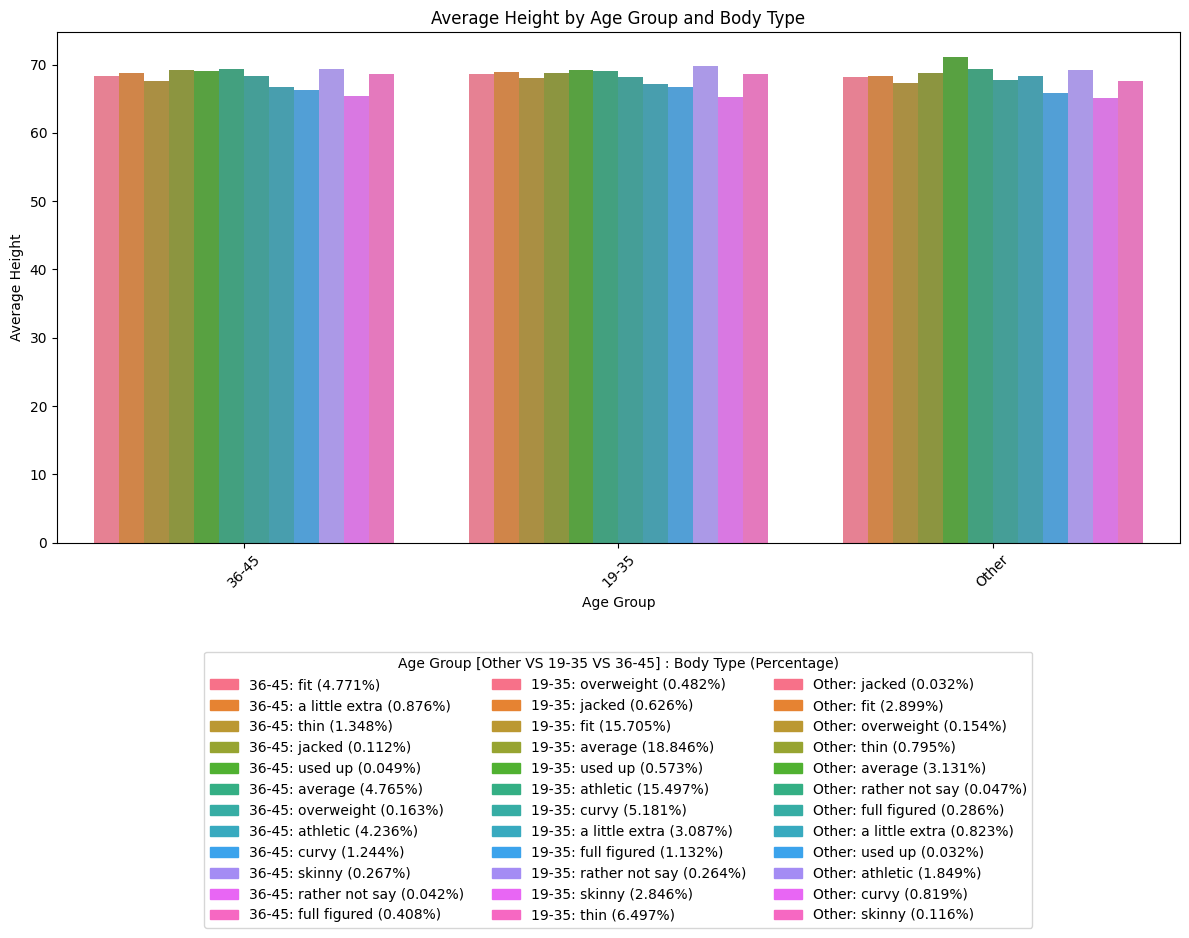

In [204]:
plot_age_body_height(matching_results)

In [205]:
# Define the aggregation pipeline
essay_pipeline = [
    # Match documents where age, body type, and essay0 fields are present
    {
        '$match': {
            '$and': [
                {'age': {'$exists': True, '$type': 'int'}},  # Ensure age is an integer
                {'body_type': {'$exists': True, '$nin': [None, '', 'null']}},
                {'essay0': {'$exists': True, '$ne': None, '$ne': '', '$ne': 'null'}}
            ]
        }
    },
    
    # Project essay0 field
    {
        '$project': {
            'age': {'$toString': '$age'},
            'essay0': {'$cond': [{'$isArray': ['$essay0']}, {'$reduce': {'input': '$essay0', 'initialValue': '', 'in': {'$concat': ['$$value', ' ', {'$toString': '$$this'}]}}}, {'$toString': {'$ifNull': ['$essay0', '']}}]}
        }
    },
    
    # Add a field to categorize age groups
    {
        '$addFields': {
            'age_group': {
                '$switch': {
                    'branches': [
                        {'case': {'$and': [{'$gte': ["$age", "19"]}, {'$lte': ["$age", "35"]}]}, 'then': "19-35"},
                        {'case': {'$and': [{'$gte': ["$age", "36"]}, {'$lte': ["$age", "45"]}]}, 'then': "36-45"},
                    ],
                    'default': "Other"
                }
            }
        }
    },
    
    # Unwind essay0
    {'$unwind': '$essay0'},
    
    # Project the essay0 field to split and filter words
    {
        '$project': {
            'words': {
                '$filter': {
                    'input': {
                        '$split': ['$essay0', ' ']
                    },
                    'as': 'word',
                    'cond': {
                        '$and': [
                            {'$ne': ['$$word', '']},
                            {'$ne': ['$$word', 'null']}
                        ]
                    }
                }
            },
            'age_group': 1
        }
    },
    
    # Unwind the words
    {'$unwind': '$words'},
]

# Execute the aggregation pipeline with allowDiskUse=True
essay_results = list(mongo_database.OKCupid.aggregate(essay_pipeline, allowDiskUse=True))

In [206]:
essay_pipeline.append(
    {
        '$group': {
            '_id': {'age_group': '$age_group', 'word': '$words'},
            'count': {'$sum': 1}
        }
    },)

In [207]:
# Execute the aggregation pipeline with allowDiskUse=True
essay_results = list(mongo_database.OKCupid.aggregate(essay_pipeline, allowDiskUse=True))

In [208]:
# Initialize empty lists for each age group
age_19_35 = []
age_36_45 = []
age_others = []

In [209]:
# Populate the lists based on age group
for item in essay_results:
    age_group = item['_id']['age_group']
    if age_group == '19-35':
        age_19_35.append(item)
    elif age_group == '36-45':
        age_36_45.append(item)
    else:
        age_others.append(item)

In [210]:
len(age_19_35)

139975

In [211]:
len(age_36_45)

76109

In [212]:
len(age_others)

55779

In [213]:
# Define the threshold
threshold = 1

# Sort and filter the list
top_100_19_35 = sorted([item for item in age_19_35 if item['count'] > threshold], key=lambda x: x['count'], reverse=True)
# Get the first 20 words from the top and the last 20 words from the bottom
selected_top_40_19_35_words = top_100_19_35[50:70] + top_100_19_35[280:300]

selected_top_40_36_45_words = sorted([item for item in age_36_45 if item['count'] > threshold], key=lambda x: x['count'], reverse=True)[260:300]

selected_top_40_other_words = sorted([item for item in age_others if item['count'] > threshold], key=lambda x: x['count'], reverse=True)[260:300]

In [218]:
selected_top_40_19_35_words[0]

{'_id': {'age_group': '19-35', 'word': 'life'}, 'count': 9168}

In [219]:
selected_top_40_36_45_words[0]

{'_id': {'age_group': '36-45', 'word': 'hiking,'}, 'count': 537}

In [220]:
selected_top_40_other_words[0]

{'_id': {'age_group': 'Other', 'word': 'makes'}, 'count': 312}

In [214]:
def essay_matching(words_list, title):
    # Extract words and counts from the list of dictionaries
    words = [item['_id']['word'] for item in words_list]
    counts = [item['count'] for item in words_list]
    
    # Create a DataFrame
    word_counts_df = pd.DataFrame({'word': words, 'count': counts})
    
    # Sort the word counts in descending order
    sorted_word_counts = word_counts_df.sort_values(by='count', ascending=False)

    # Plot the top 40 most common words
    plt.figure(figsize=(30, 15))  # Increase the width and height of the graph
    #bars = plt.bar(sorted_word_counts.head(30)['word'], sorted_word_counts.head(30)['count'], color='lightcoral')  # Change bar color
    bars = plt.bar(sorted_word_counts.head(30)['word'], sorted_word_counts.head(30)['count'], color=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])

    plt.title(title, fontsize=20)
    plt.xlabel('Words', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Annotate bar values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 10, round(yval, 2), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

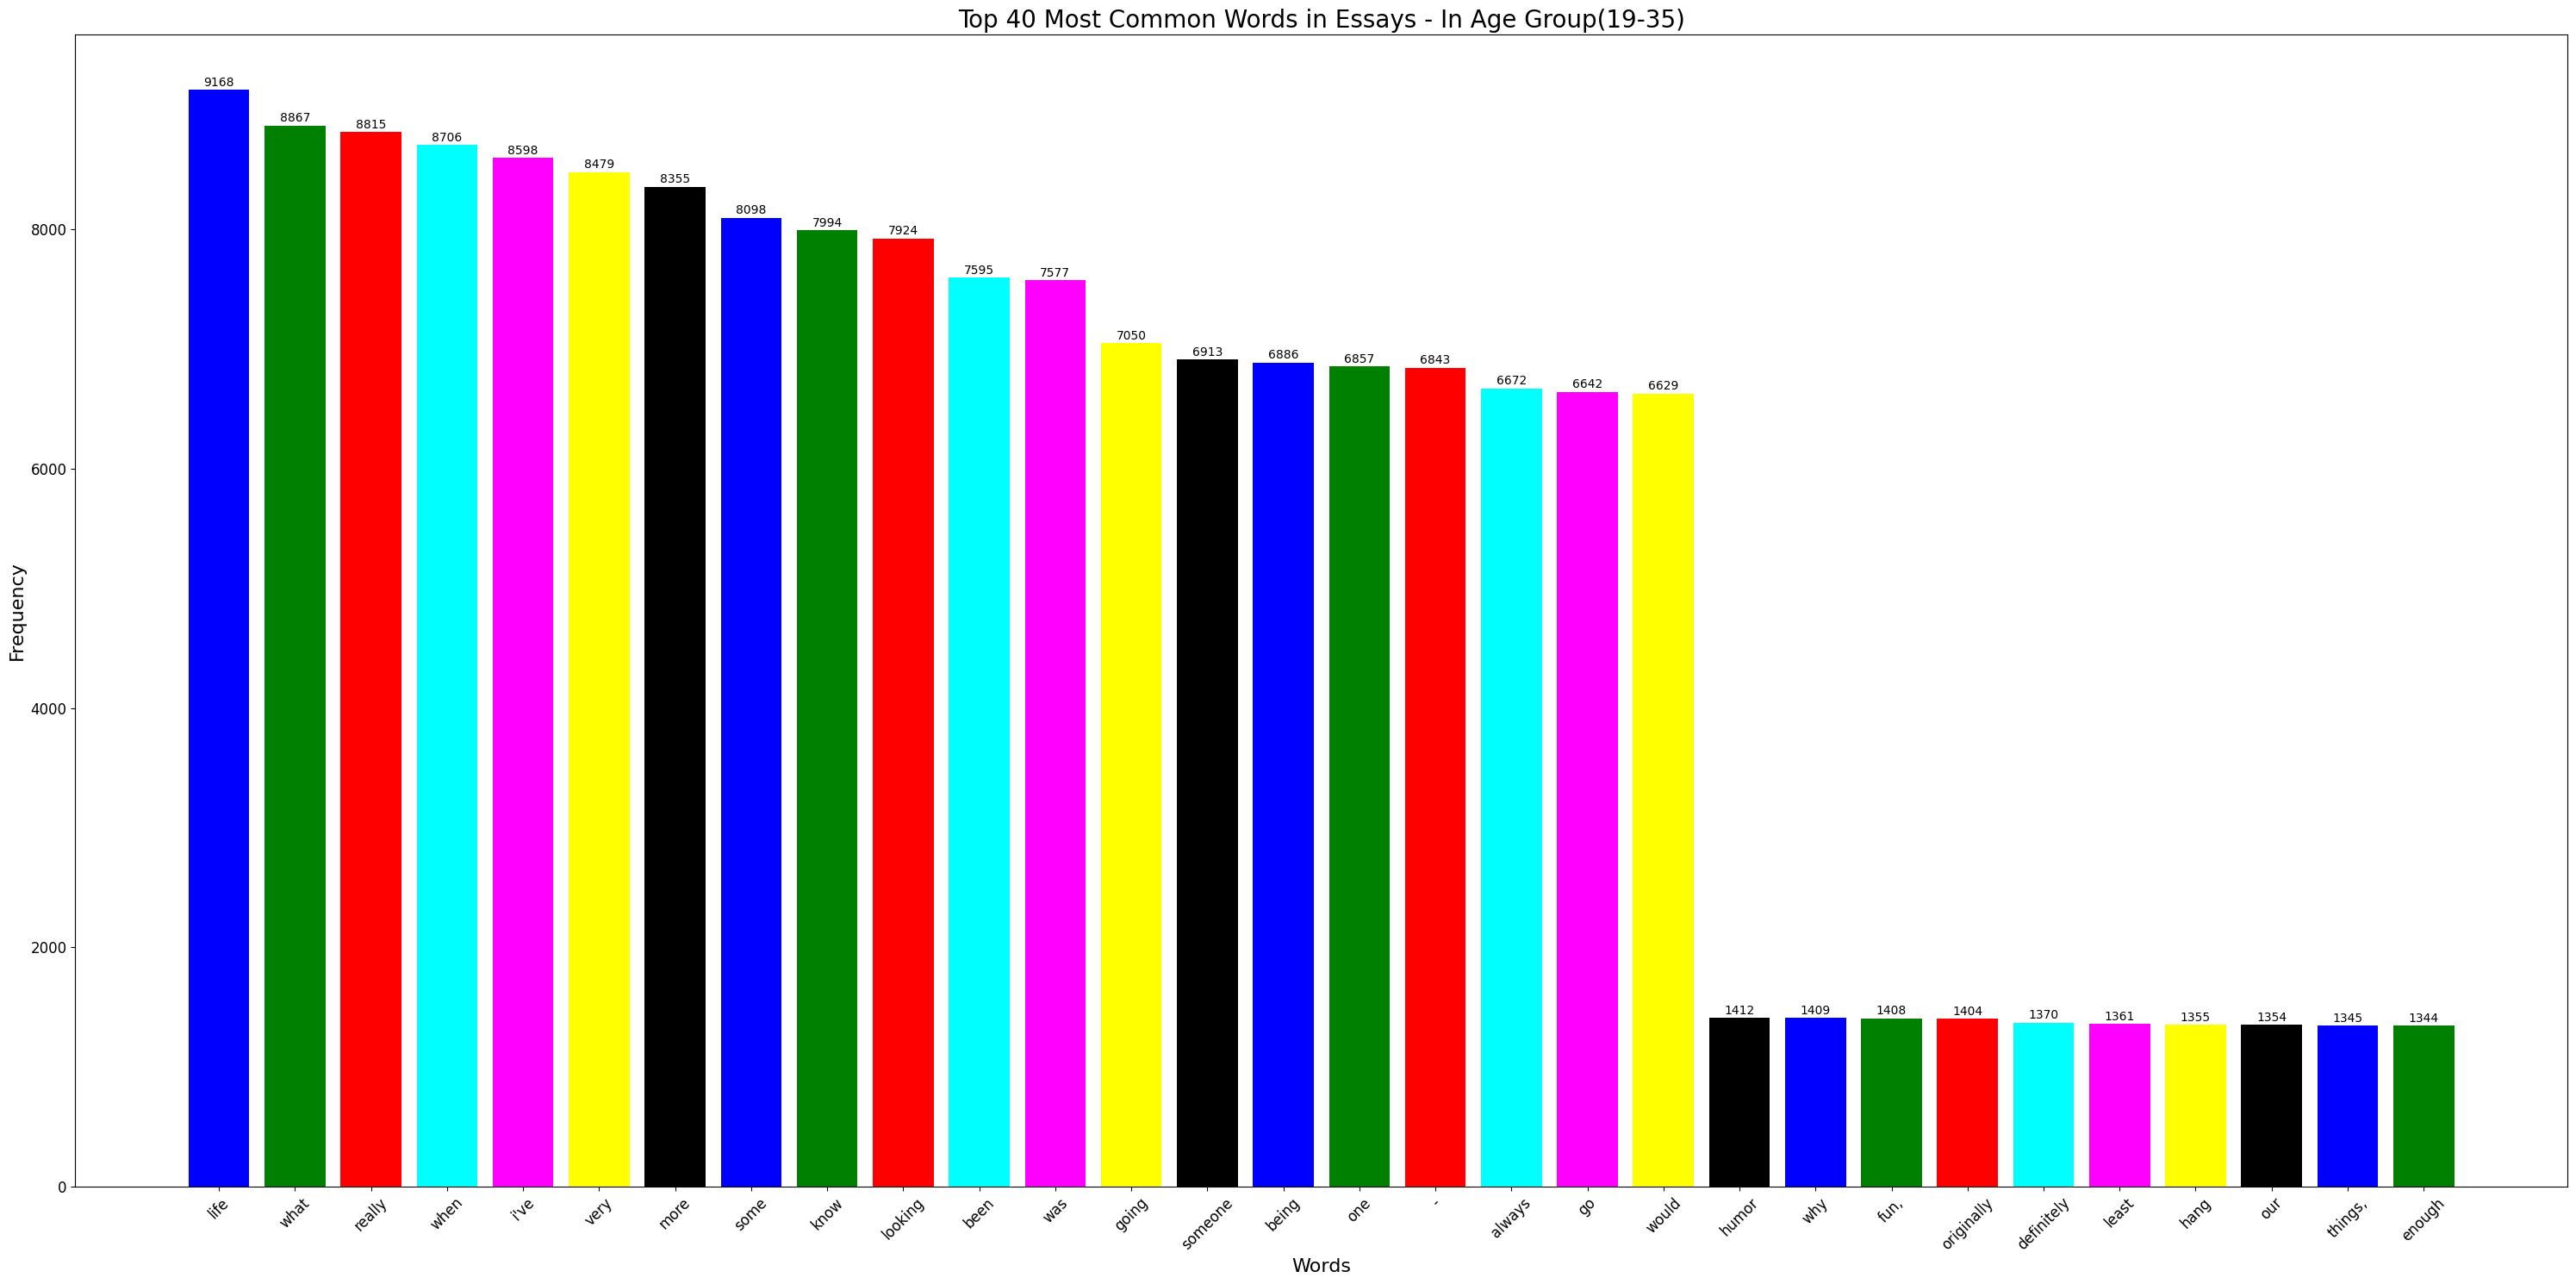

In [215]:
# Plot for '19-35' Age Group
essay_matching(selected_top_40_19_35_words, 'Top 40 Most Common Words in Essays - In Age Group(19-35)')

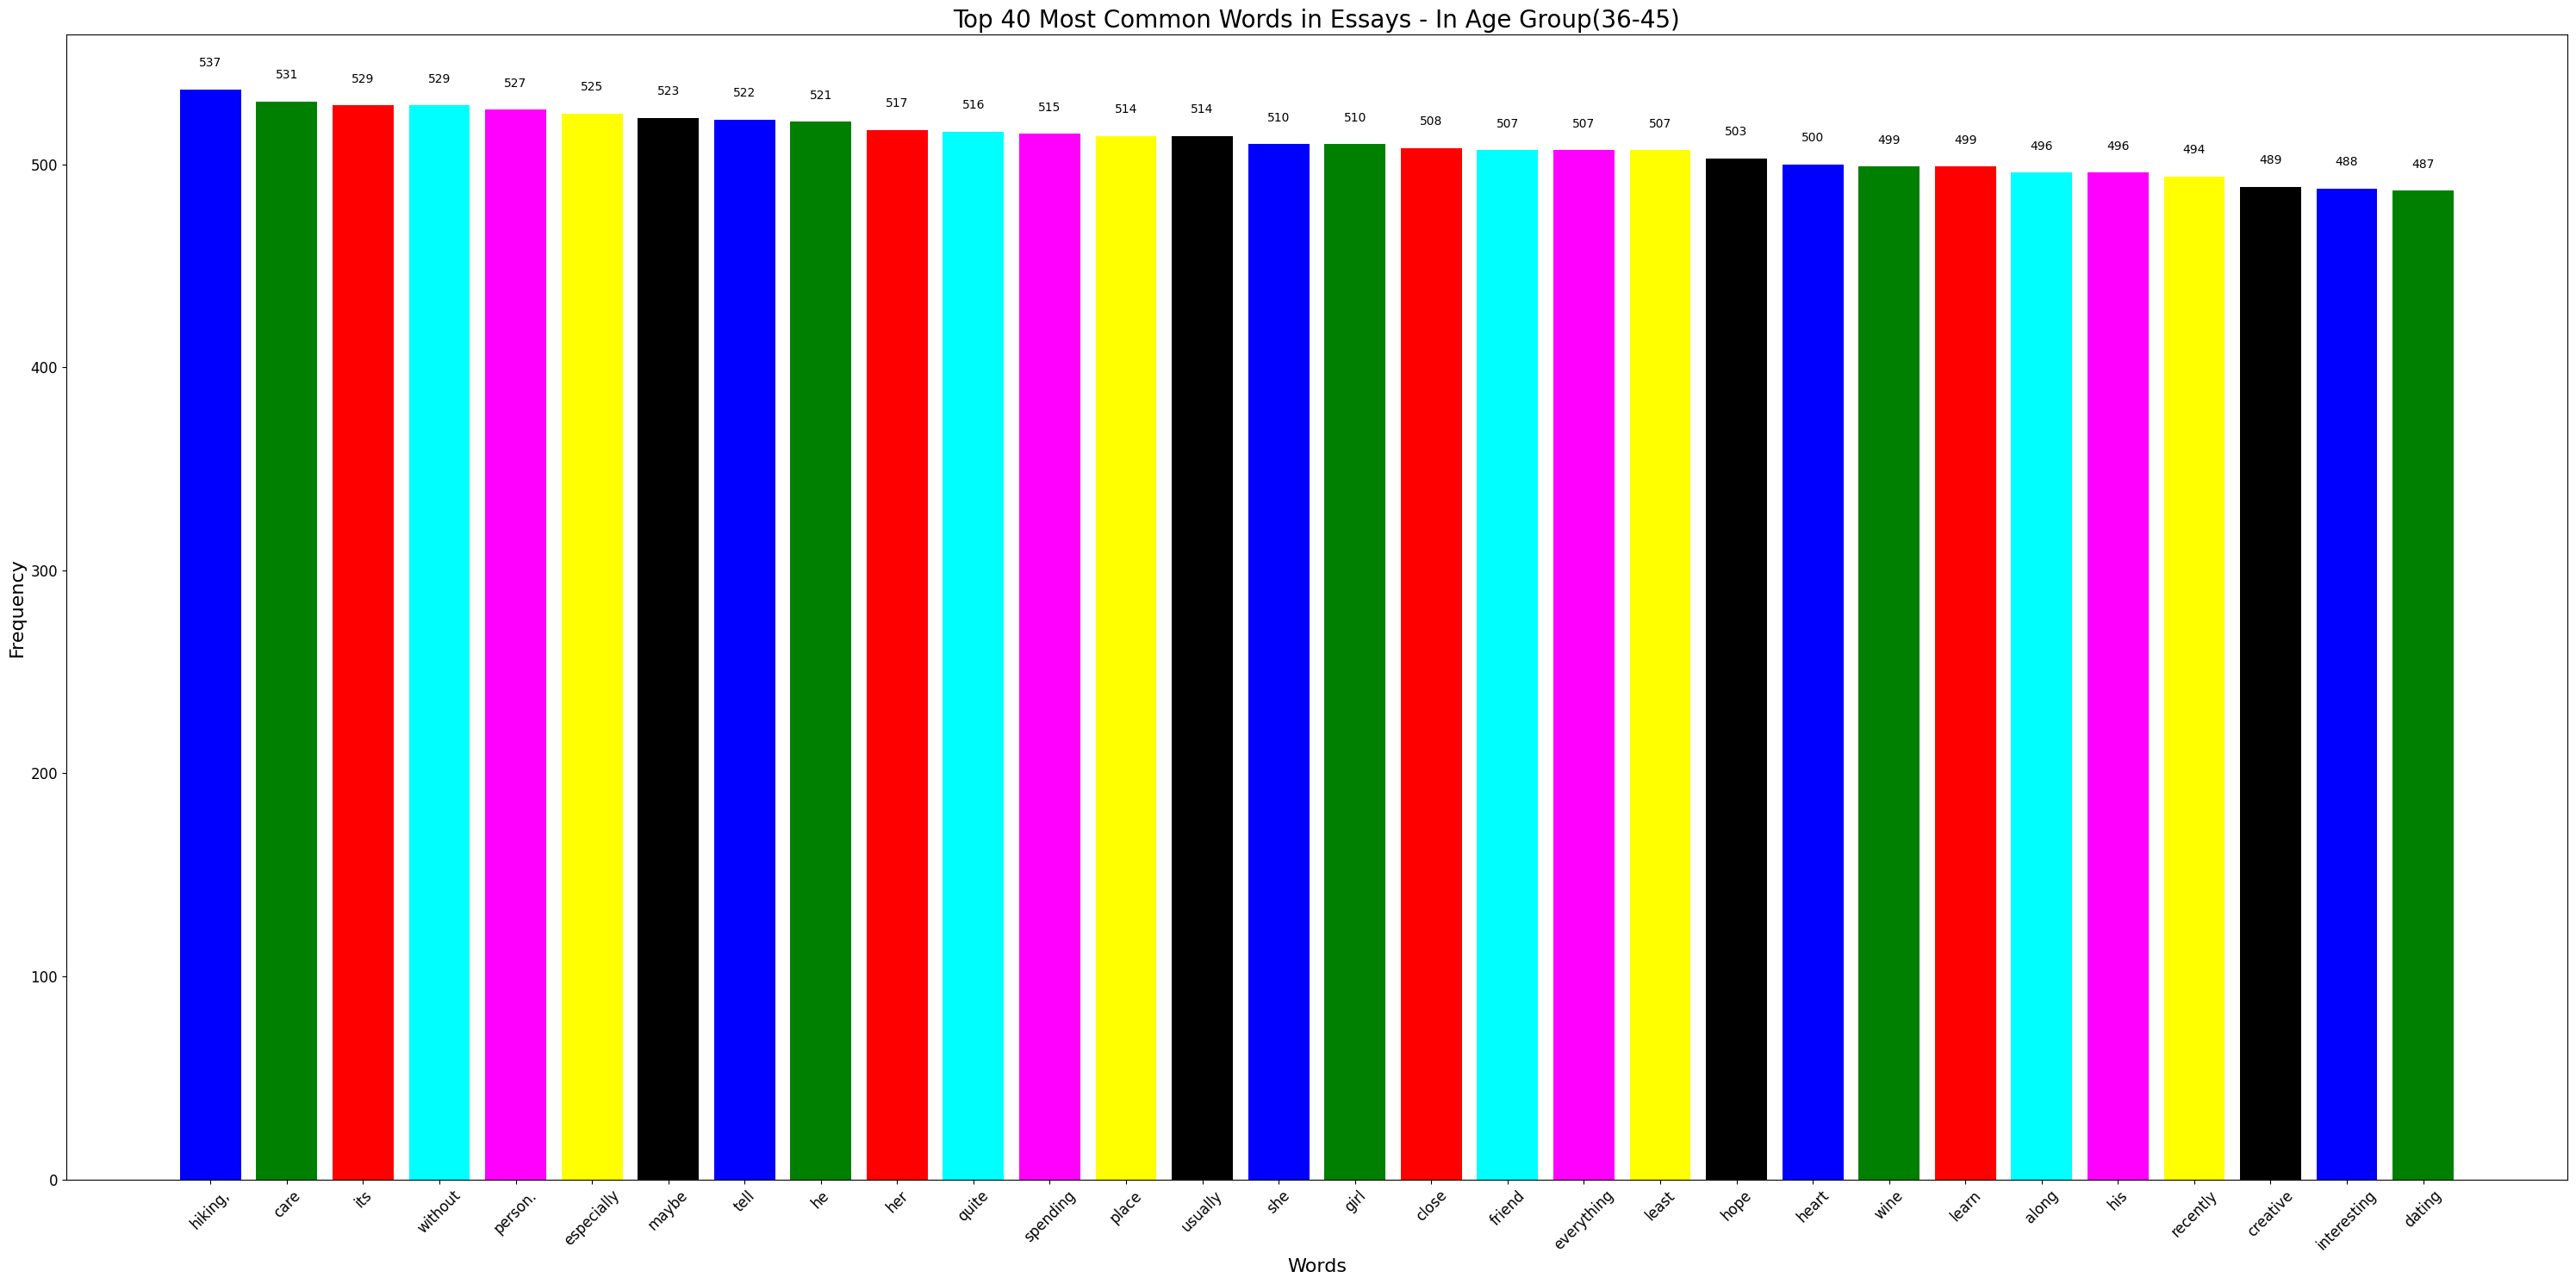

In [216]:
# Plot for '36-45' Age Group
essay_matching(selected_top_40_36_45_words, 'Top 40 Most Common Words in Essays - In Age Group(36-45)')

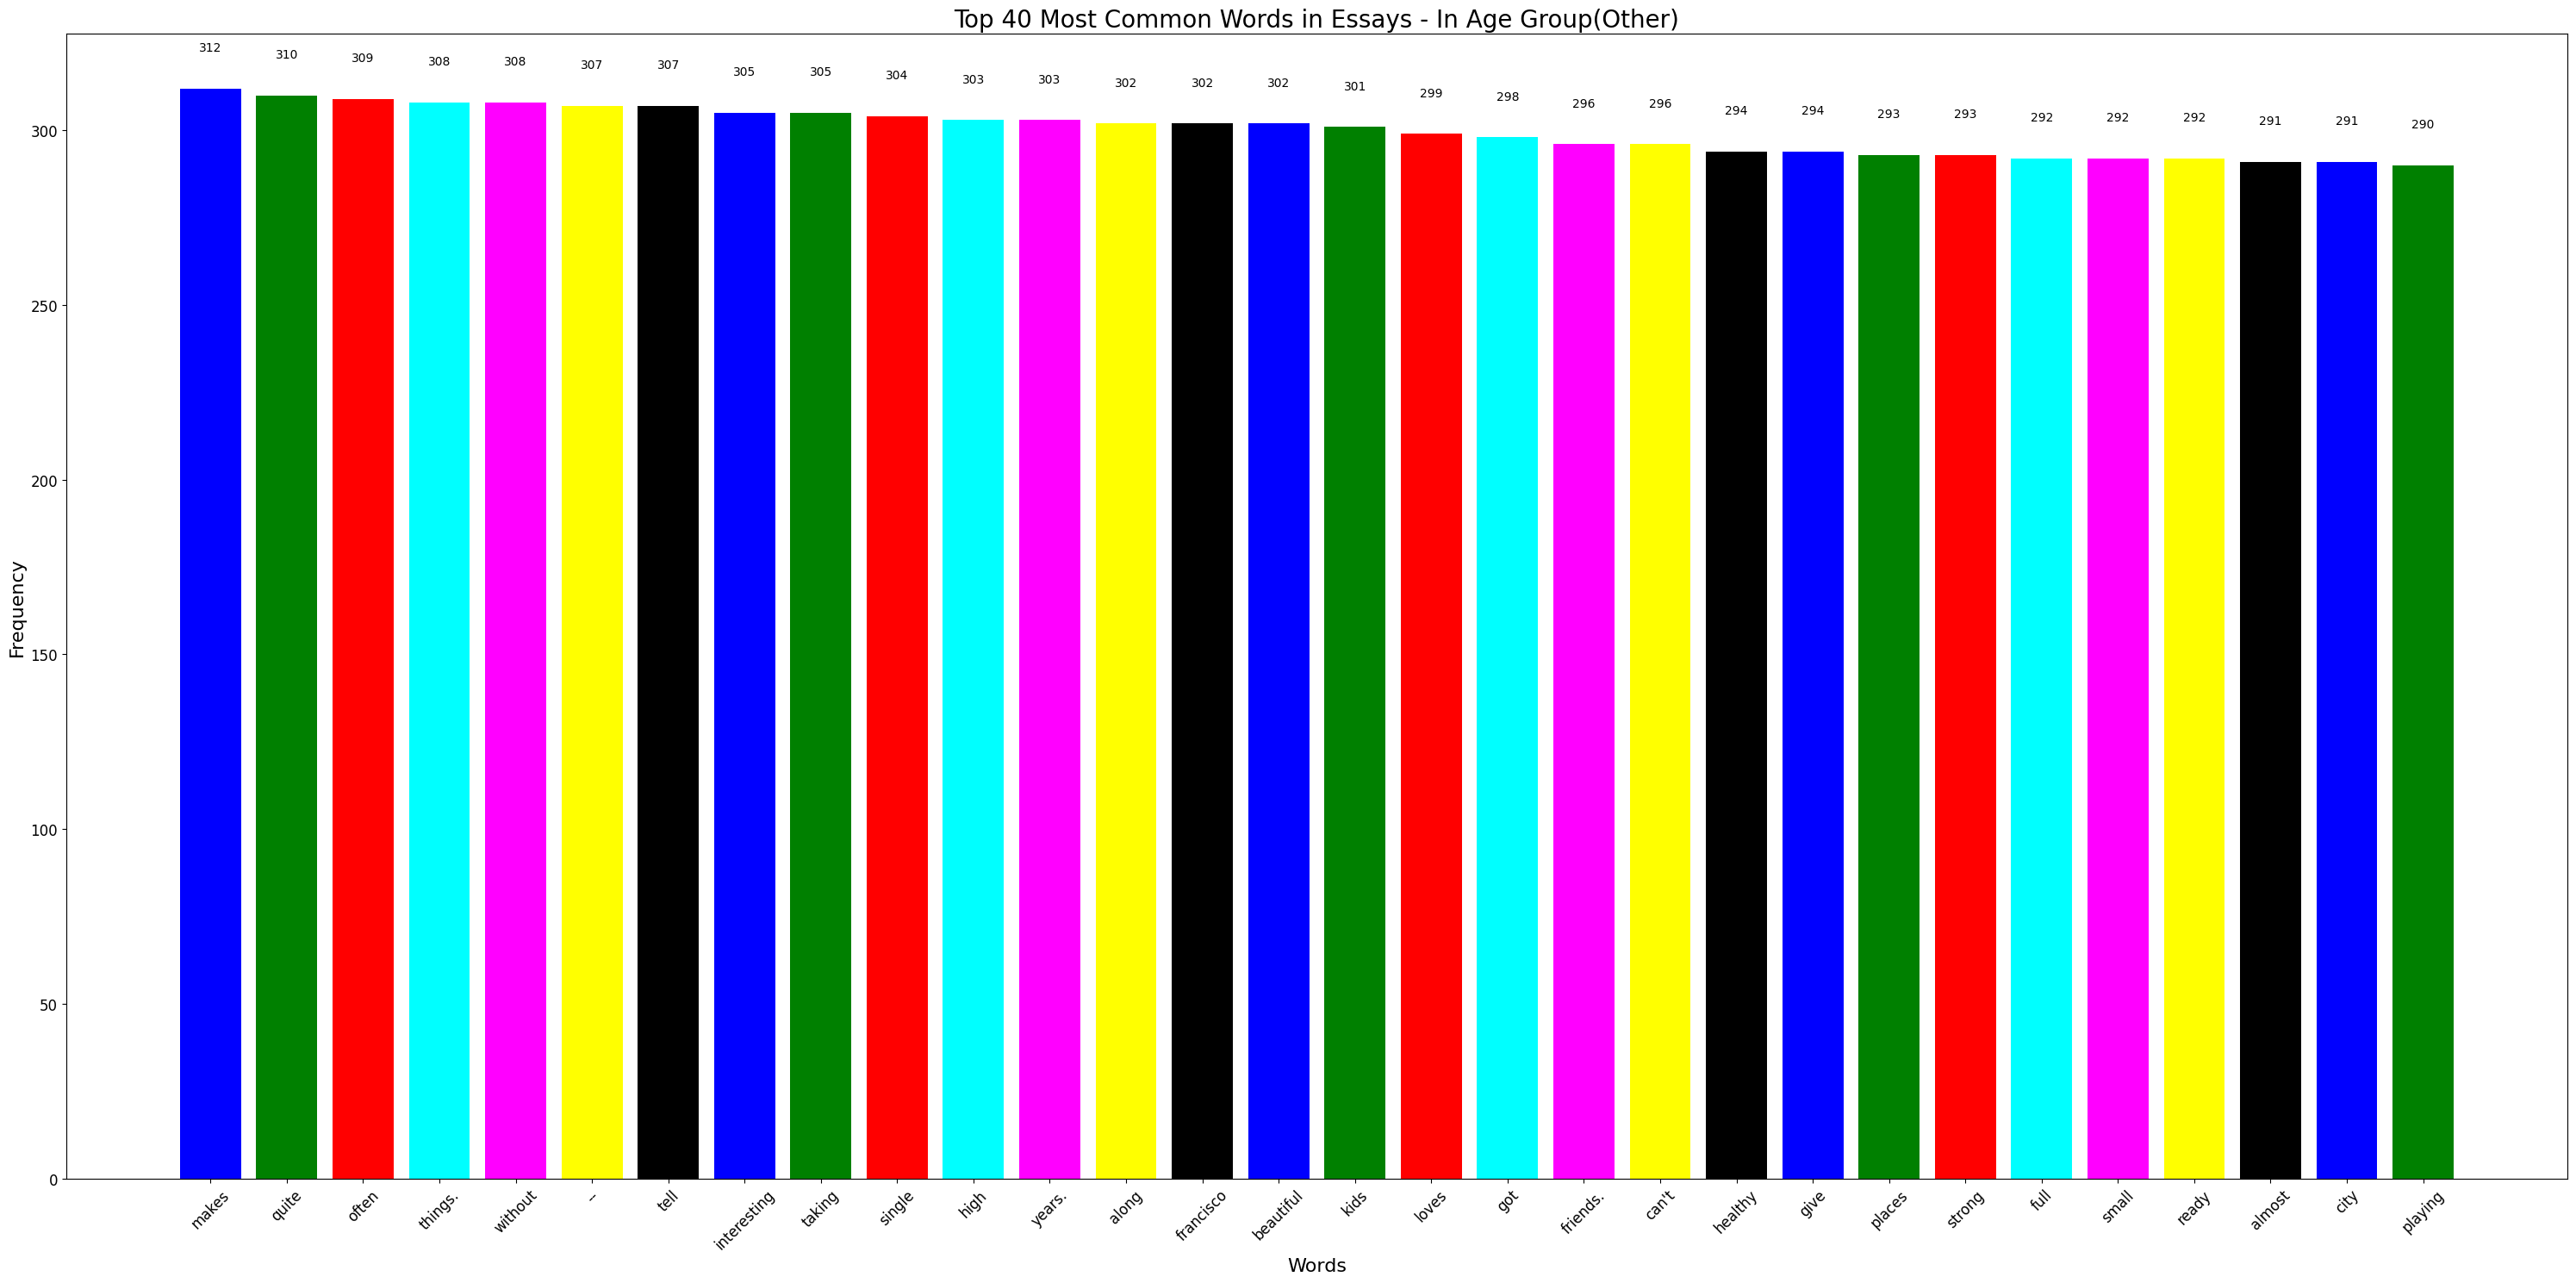

In [217]:
# Plot for 'Other' Age Group
essay_matching(selected_top_40_other_words, 'Top 40 Most Common Words in Essays - In Age Group(Other)')